In [1]:
from machinelearning.mlpipeline import MLPipelines
from machinelearning.featexpl import FeaturesExplanation

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import optuna
import pandas as pd
# from sklearn.preprocessing import LabelEncoder ###
# from sklearn.cross_decomposition import PLSRegression

# model = LogisticRegression()
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1],
#     'penalty': ['l1', 'l2']
# }
csv_dir = 'data/composite_dataset.csv'
label = 'group'

model = LogisticRegression()
param_grid = {
    'n_estimators': [10, 20, 50],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# mlpipe = MLPipelines(estimator=model, param_grid=param_grid, label=label, csv_dir=csv_dir)
# mlpipe.normalize()

/home/spyros/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # dataloader
# mlpipe = MLPipelines(estimator=model, param_grid={}, label=label, csv_dir=csv_dir)
# # mlpipe._encode_labels()
# mlpipe.normalize()
# # mlpipe.feature_selection(method='mrmr', n_features=20, inner_method='chi2')

In [3]:
# mlpipe.bayesian_search()
# xg = [RandomForestClassifier(), GradientBoostingClassifier(), LinearDiscriminantAnalysis(), LogisticRegression(), GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier(), SVC()]
# xg = [LinearDiscriminantAnalysis(), XGBClassifier(), GradientBoostingClassifier(), GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier(), SVC()]

In [4]:
# fitted_mod = mlpipe.model_selection(optimizer='bayesian_search',n_trials=2,num_trials=2,score='accuracy',exclude=xg, n_iter=2, train_best='bayesian_search',return_model=True)#, exclude=[XGBClassifier()],result=True)

In [5]:
# import pickle
# filename = 'fitted_10.sav'
# # # pickle.dump(fitted_mod, open(filename, 'wb'))
# fitted_mod = pickle.load(open(filename, 'rb'))

# dataloader
mlpipe = MLPipelines(estimator=model, param_grid={}, label=label, csv_dir=csv_dir)
# mlpipe._encode_labels()
mlpipe.normalize()
mlpipe.feature_selection(method='mrmr', n_features=10, inner_method='chi2')


Label mapping: {0: 'Factor1:CASE', 1: 'Factor1:CONTROL'}


100%|██████████| 10/10 [00:00<00:00, 17.73it/s]


In [9]:
# fitted_mod = XGBClassifier(booster='gbtree').fit(mlpipe.X, mlpipe.y)
fitted_mod = RandomForestClassifier().fit(mlpipe.X, mlpipe.y)

In [10]:
fesel = FeaturesExplanation(best_estimator=fitted_mod, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping)
fesel.calculate_shap_values(explainer_type='tree')

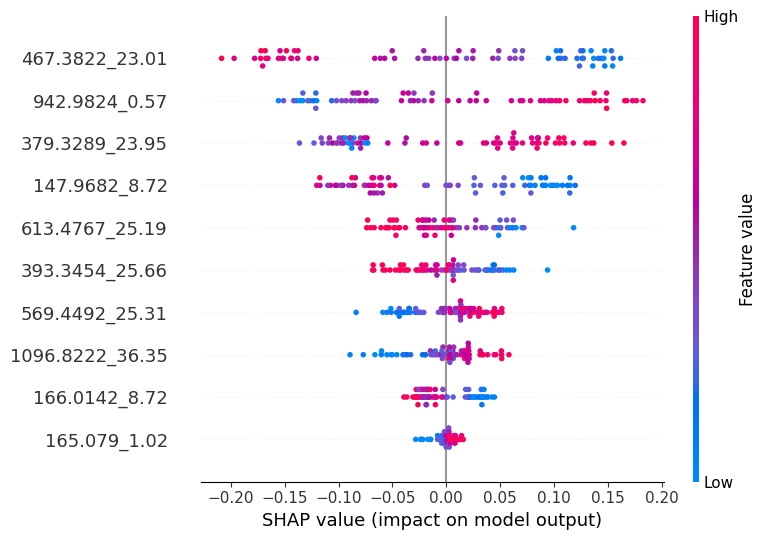

The plot is for label 0, corresponding to Factor1:CASE


In [11]:
fesel.plot_shap_values(plot_type='summary',label=0)

The plot is for label 0, of factors {'Factor1:CASE': 0, 'Factor1:CONTROL': 1}


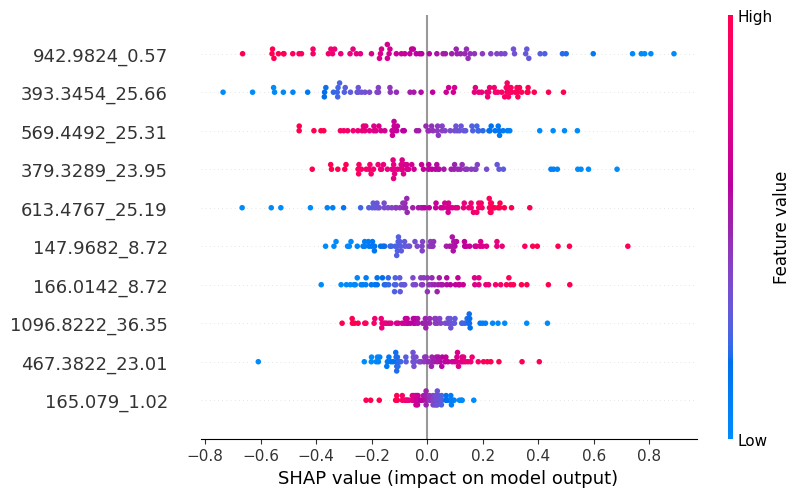

In [23]:
fesel.plot_shap_values(plot_type='beeswarm')

In [10]:
stop

NameError: name 'stop' is not defined

**χερατα**

In [18]:
from dash import Dash, dcc, html, Input, Output
# from sklearn.datasets import load_boston
from sklearn.decomposition import PCA
import plotly.express as px
# import pandas as pd

app = Dash(__name__)

app.layout = html.Div([
    html.H4("Visualization of PCA's explained variance"),
    dcc.Graph(id="graph"),
    html.P("Number of components:"),
    dcc.Slider(
        id='slider',
        min=2, max=5, value=3, step=1)
])


@app.callback(
    Output("graph", "figure"), 
    Input("slider", "value"))
def run_and_plot(n_components):
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(fesel.X)

    var = pca.explained_variance_ratio_.sum() * 100
    labels=[]
    for lab in fesel.label_mapping.keys():
        labels.append(fesel.label_mapping[lab])

    fig = px.scatter_matrix(
        components,
        color=fesel.y,
        dimensions=range(n_components),
        labels=labels,
        title=f'Total Explained Variance: {var:.2f}%')
    fig.update_traces(diagonal_visible=False)
    return fig


app.run_server(debug=True)